In [2]:
import tensorflow as tf
print(tf.__version__) 

2.5.0


# The Sequential model API

 ## Coding tutorials
 #### [1. Building a Sequential model](#coding_tutorial_1)
 #### [2. Convolutional and pooling layers](#coding_tutorial_2)
 #### [3. The compile method](#coding_tutorial_3)
 #### [4. The fit method](#coding_tutorial_4)
 #### [5. The evaluate and predict methods](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Building a Sequential model

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Softmax

#### Build a feedforward neural network model

In [4]:
# Build the Sequential feedforward neural network model

model = Sequential([
                    Flatten(input_shape=(28,28)),
                    Dense(16, activation='relu', name='layer_1'),
                    Dense(16, activation='relu', name='layer_2'),
                    Dense(10, activation='softmax', name='output_layer')
])

In [5]:
# Print the model summary
model.weights
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
layer_1 (Dense)              (None, 16)                12560     
_________________________________________________________________
layer_2 (Dense)              (None, 16)                272       
_________________________________________________________________
output_layer (Dense)         (None, 10)                170       
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________


***
<a id="coding_tutorial_2"></a>
## Convolutional and pooling layers

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

#### Build a convolutional neural network model

In [28]:
# Build the Sequential convolutional neural network model
model = Sequential([
                    Conv2D(16, (3,3), activation='relu', input_shape=(28,28,1), padding='SAME'),
                    MaxPooling2D((3,3)),
                    Flatten(),
                    Dense(10, activation='softmax')
])


In [29]:
# Print the model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1296)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                12970     
Total params: 13,130
Trainable params: 13,130
Non-trainable params: 0
_________________________________________________________________


***
<a id="coding_tutorial_3"></a>
## The compile method

#### Compile the model

In [30]:
# Define the model optimizer, loss function and metrics
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy','mae'])


In [31]:
# Print the resulting model attributes
print(model.loss)
print(model.optimizer)
print(model.metrics)

sparse_categorical_crossentropy
[]


***
<a id="coding_tutorial_4"></a>
## The fit method

In [32]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### Load the data

In [33]:
# Load the Fashion-MNIST dataset

fashion_mnist_data = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist_data.load_data()

In [34]:
# Print the shape of the training data
print(train_images.shape)
print(train_labels.shape)

(60000, 28, 28)
(60000,)


In [35]:
# Define the labels

labels = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

In [36]:
# Rescale the image values so that they lie in between 0 and 1.

train_images = train_images /255.
test_images = test_images / 255.

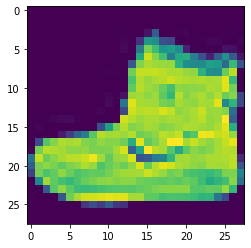

label: Ankle boot


In [37]:
# Display one of the images

i = 0
img = train_images[i,:,:]
plt.imshow(img)
plt.show()
print(f"label: {labels[train_labels[i]]}")

#### Fit the model

In [39]:
# Fit the model
history = model.fit(train_images[..., np.newaxis], train_labels, epochs=8, batch_size=256, verbose=2)

Epoch 1/8
235/235 - 14s - loss: 0.3923 - accuracy: 0.8637 - mae: 4.4200
Epoch 2/8
235/235 - 14s - loss: 0.3644 - accuracy: 0.8734 - mae: 4.4200
Epoch 3/8
235/235 - 14s - loss: 0.3469 - accuracy: 0.8786 - mae: 4.4200
Epoch 4/8
235/235 - 14s - loss: 0.3333 - accuracy: 0.8835 - mae: 4.4200
Epoch 5/8
235/235 - 14s - loss: 0.3227 - accuracy: 0.8871 - mae: 4.4200
Epoch 6/8
235/235 - 14s - loss: 0.3136 - accuracy: 0.8913 - mae: 4.4200
Epoch 7/8
235/235 - 14s - loss: 0.3069 - accuracy: 0.8924 - mae: 4.4200
Epoch 8/8
235/235 - 14s - loss: 0.3001 - accuracy: 0.8952 - mae: 4.4200


#### Plot training history

In [40]:
# Load the history into a pandas Dataframe
df = pd.DataFrame(history.history)
df.head()

,loss,accuracy,mae
0,0.392266,0.863667,4.420001
1,0.364414,0.873400,4.419999
2,0.346941,0.878583,4.420001
3,0.333322,0.883483,4.419999
4,0.322694,0.887083,4.420001


[Text(0, 0.5, 'Loss'), Text(0.5, 0, 'Epochs')]

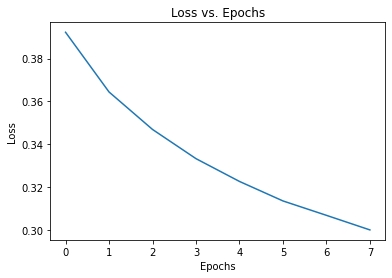

In [41]:
# Make a plot for the loss

loss_plot = df.plot(y='loss', title='Loss vs. Epochs', legend=False)
loss_plot.set(xlabel='Epochs', ylabel='Loss')

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epochs')]

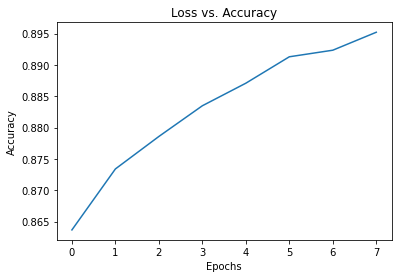

In [42]:
# Make a plot for the accuracy
loss_plot = df.plot(y='accuracy', title='Loss vs. Accuracy', legend=False)
loss_plot.set(xlabel='Epochs', ylabel='Accuracy')

[Text(0, 0.5, 'MAE'), Text(0.5, 0, 'Epochs')]

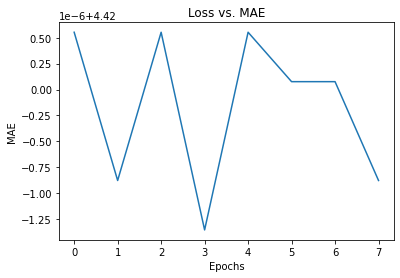

In [43]:
# Make a plot for the additional metric
loss_plot = df.plot(y='mae', title='Loss vs. MAE', legend=False)
loss_plot.set(xlabel='Epochs', ylabel='MAE')

***
<a id="coding_tutorial_5"></a>
## The evaluate and predict methods

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#### Evaluate the model on the test set

In [ ]:
# Evaluate the model



#### Make predictions from the model

In [ ]:
# Choose a random test image

random_inx = np.random.choice(test_images.shape[0])

test_image = test_images[random_inx]
plt.imshow(test_image)
plt.show()
print(f"Label: {labels[test_labels[random_inx]]}")

In [ ]:
# Get the model predictions

